In [1]:
import itertools
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
from vertex_model.run_select import run_simulation_INM, definecolors

In [2]:
#### Global parameter used in the simulation are picked up from Gobal_Constant.py file

### Choose simulation to run
#def run_simulation_INM(x, timend,rand, type):
    #sim_type 0 simulation_with_division_clone (no differentiation rate)
    #sim_type 1 simulation_with_division_clone_whole_tissue_differenciation (differentiation rate everywhere)
    #sim_type 2 simulation_with_division_clone_differenciation_3stripes (2 population with and without diffentiation rate)
    
type_=2
## Hamiltonian is K(A-A0(t))
K=1.0 
G= 0.04
L=0.075
#run simulation with the choosen parameters
rand =  np.random.RandomState() #random number to choose Lambda
params = [K,G,L]  # K=x[0],G=x[1],L=x[2]
history_start,history_end= run_simulation_INM(params,150,rand,type_) #return hist

history = history_start+history_end



In [3]:
#define cell colors: Red for pMN domain and peach for pD domain
#also random clones (sampleset) in each domain are plotting blue in pMN and green in pD
def definecolors(cells, sampleset):
    peach = '#eed5b7'
    light_blue ='#87cefa'
    pink = '#ffc0cb'
    light_green = '#98fb98'
    palette = np.array([peach, 'r', peach,light_green,light_blue,light_green])
#     colors = cells.properties['parent_group']
    colors = cells.properties['parent_group']+np.array([3 if x in sampleset else 0 for x in cells.properties['parent']])
    return palette[colors]
#ids of the random clones
pd_0=np.random.choice(np.where((history_end[0].properties['parent_group']==0) & (~history_end[0].empty()))[0], 8)
pd_2=np.random.choice(np.where((history_end[0].properties['parent_group']==2) & (~history_end[0].empty()))[0], 8)
pmn=np.random.choice(np.where((history_end[0].properties['parent_group']==1) & (~history_end[0].empty()))[0], 8)
sampleset =np.append(np.append(pd_0,pd_2),pmn)

for cells in history:
    cells.properties['color'] = definecolors(cells,sampleset)


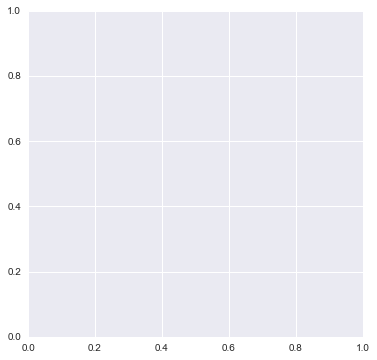

In [4]:
# definition of the frame for the interactive video
fig=plt.figure()
fig.set_size_inches(6,6);
ax = fig.gca()
# initialization function: plot the background of each frame
def init_fig():
    ax = plt.figure()
    
    return (ax,)
# animation function. This is called sequentially
def animate_fig(i):
    cells_array=history
    v_max = np.max((np.max(cells_array[0].mesh.vertices), np.max(cells_array[-1].mesh.vertices)))
    size = 2.0*v_max
    cells= history[i]
    return model.draw(cells,ax,size)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,animate_fig, init_func=init_fig,
                               frames=len(history))


In [5]:
#interactive video of the simulation
HTML(anim.to_html5_video())

In [6]:
###### Save simulation information figures
import os
outputdirname="figures"
if not os.path.exists(outputdirname): # if the folder doesn't exist create it
    os.makedirs(outputdirname)
outputdirname=outputdirname+'/'

In [7]:
#Total number of cells
number_cells=[len(cells.mesh.area[~cells.empty()]) for cells in history]
plt.plot(number_cells,'-')
plt.xlabel('Time')
plt.ylabel('Total number of cells')
plt.tight_layout()
plt.savefig(outputdirname+'cells_time.pdf')

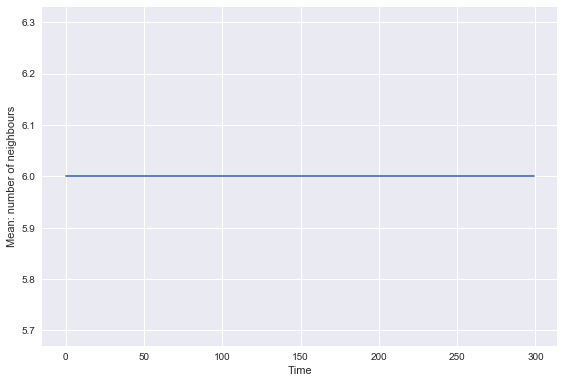

In [8]:
plt.figure()
#Total mean of number of neigh
number_neigh=[np.mean(cells.mesh.edge_counts()[~cells.empty()]) for cells in history]
plt.plot(number_neigh,'-')
plt.xlabel('Time')
plt.ylabel('Mean: number of neighbours')
plt.tight_layout()
plt.savefig(outputdirname+'neigbours_time.pdf')

Text(0,0.5,u'$P_n$')

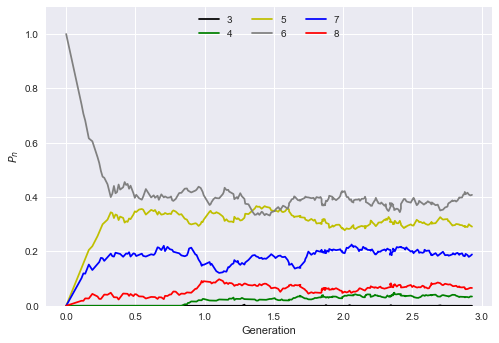

In [9]:
counts = [np.bincount(np.bincount(cells.mesh.face_id_by_edge)) for cells in history]
generation = [np.log(len(cells.mesh.face_id_by_edge))/np.log(2) for cells in history]
generation -= generation[0]
all_counts = np.zeros((len(counts),30))
for i,c in enumerate(counts):
    all_counts[i,:len(c)] = c
f = all_counts[:,3:9]
f = f/np.sum(all_counts[:,1:],1)[:,None]
import matplotlib.pyplot as plt
fig = plt.figure()
colors = ['k','g','y','0.5','b','r']
for i in range(6):  
    plt.plot(generation,f[:,i],c=colors[i])
plt.ylim([0,1.1]); 
#plt.yticks(np.arange(0,0.7,0.1))
plt.legend(('3','4','5','6','7','8'),loc=9,ncol=3)
plt.xlabel('Generation')
plt.ylabel('$P_n$')

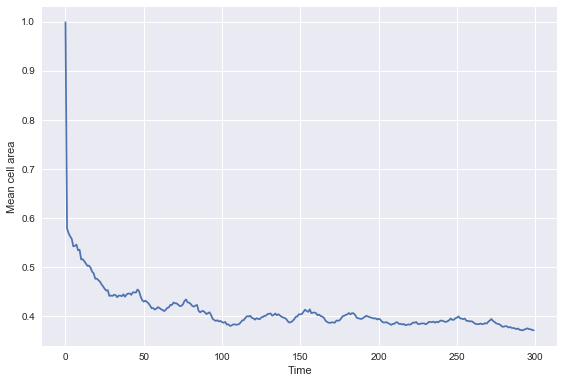

In [10]:
plt.figure()
#cell area
number_cells=[np.mean(cells.mesh.area[~cells.empty()]) for cells in history]
plt.plot(number_cells,'-')
plt.xlabel('Time')
plt.ylabel('Mean cell area')
plt.tight_layout()
plt.savefig(outputdirname+'areas_time.pdf')

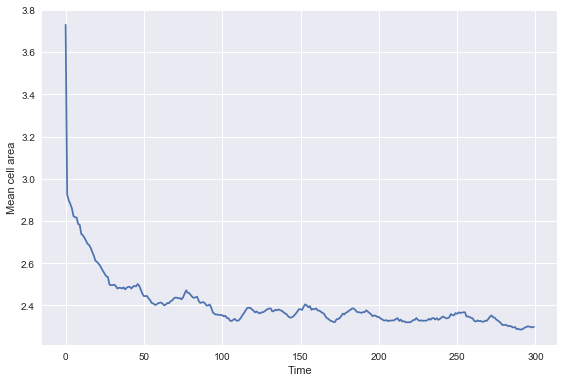

In [11]:
plt.figure()
#cell area
number_cells=[np.mean(cells.mesh.perimeter[~cells.empty()]) for cells in history]
plt.plot(number_cells,'-')
plt.xlabel('Time')
plt.ylabel('Mean cell area')
plt.tight_layout()
plt.savefig(outputdirname+'perimeter_time.pdf')

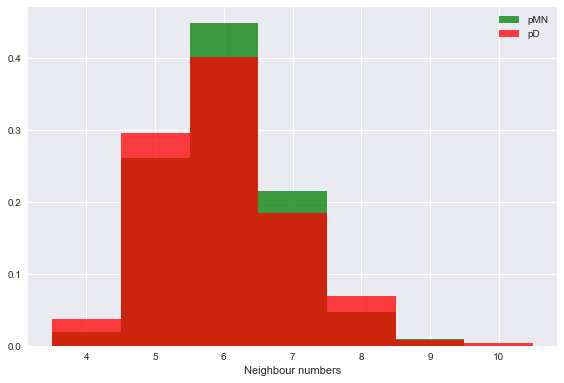

In [12]:
plt.figure()
cells= history[-1].copy()
index_pmn= np.where((~cells.empty()) & (cells.properties['parent_group']==1))[0]
data = cells.mesh.edge_counts()[index_pmn]
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
a,b,c=plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d),  normed=1, facecolor='green', alpha=0.75,label='pMN')

index_pd= np.where((~cells.empty()) & ~(cells.properties['parent_group']==1))[0]
data = cells.mesh.edge_counts()[index_pd]
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
a,b,c=plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d),  normed=1, facecolor='red', alpha=0.75, label='pD')

plt.legend(loc='best')
plt.xlabel('Neighbour numbers')
plt.tight_layout()
plt.savefig(outputdirname+'number_neighbours_hist.pdf')

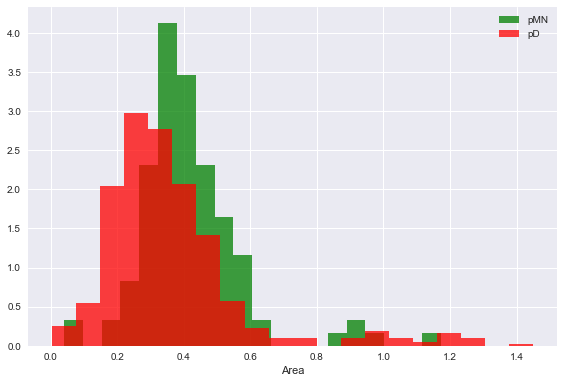

In [13]:
plt.figure()
cells= history[-1].copy()
index_pmn= np.where((~cells.empty()) & (cells.properties['parent_group']==1))[0]
data = cells.mesh.area[index_pmn]
data = np.array(data)

nbins=20
a,b,c=plt.hist(data, bins=nbins,  normed=1, facecolor='green', alpha=0.75,label='pMN')

index_pd= np.where((~cells.empty()) & ~(cells.properties['parent_group']==1))[0]
data = cells.mesh.area[index_pd]
data = np.array(data)

a,b,c=plt.hist(data, bins=nbins,  normed=1, facecolor='red', alpha=0.75, label='pD')

plt.legend(loc='best')
plt.xlabel('Area')
plt.tight_layout()
plt.savefig(outputdirname+'area_hist.pdf')

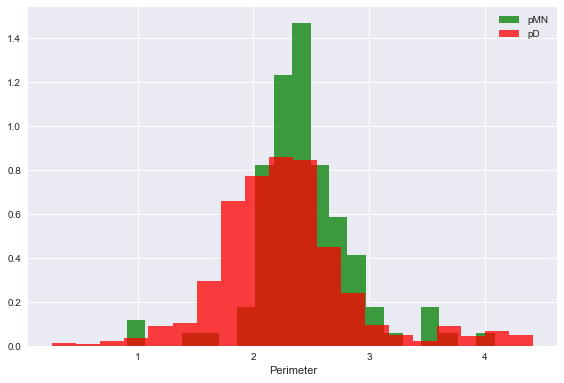

In [15]:
plt.figure()
cells= history[-1].copy()
index_pmn= np.where((~cells.empty()) & (cells.properties['parent_group']==1))[0]
data = cells.mesh.perimeter[index_pmn]
data = np.array(data)

a,b,c=plt.hist(data, bins=nbins,  normed=1, facecolor='green', alpha=0.75,label='pMN')

index_pd= np.where((~cells.empty()) & ~(cells.properties['parent_group']==1))[0]
data = cells.mesh.perimeter[index_pd]
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
a,b,c=plt.hist(data, bins=nbins,  normed=1, facecolor='red', alpha=0.75, label='pD')

plt.legend(loc='best')
plt.xlabel('Perimeter')
plt.tight_layout()
plt.savefig(outputdirname+'perimeter_hist.pdf')